In [1]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.16.1'

# h5 File

In [3]:
train_file = h5py.File('train_signs.h5', "r")
test_file = h5py.File('test_signs.h5', "r")

In [4]:
for item in train_file.keys():
    print(item, ':', train_file[item])

list_classes : <HDF5 dataset "list_classes": shape (6,), type "<i8">
train_set_x : <HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">
train_set_y : <HDF5 dataset "train_set_y": shape (1080,), type "<i8">


In [5]:
for item in test_file.keys():
    print(item, ':', test_file[item])

list_classes : <HDF5 dataset "list_classes": shape (6,), type "<i8">
test_set_x : <HDF5 dataset "test_set_x": shape (120, 64, 64, 3), type "|u1">
test_set_y : <HDF5 dataset "test_set_y": shape (120,), type "<i8">


# Tensor Dataset & Tensor Data Type

In [6]:
tf.convert_to_tensor(test_file['list_classes'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 5], dtype=int64)>

In [7]:
x_train_Dataset = tf.data.Dataset.from_tensor_slices(train_file['train_set_x'])
y_train_Dataset = tf.data.Dataset.from_tensor_slices(train_file['train_set_y'])

x_test_Dataset = tf.data.Dataset.from_tensor_slices(test_file['test_set_x'])
y_test_Dataset = tf.data.Dataset.from_tensor_slices(test_file['test_set_y'])

`tf.data.Dataset.from_tensor_slices()` is a method in TensorFlow that slices the input tensor(s) along the first dimension and creates a `tf.data.Dataset`

In [8]:
x_train_Dataset, y_train_Dataset, x_test_Dataset, y_test_Dataset

(<_TensorSliceDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)>,
 <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>,
 <_TensorSliceDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)>,
 <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>)

In [9]:
x_train_Dataset.element_spec, y_train_Dataset.element_spec

(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

TensorFlow Datasets (`tf.data.Dataset`) are generators, so you can't directly access their contents without iterating over them. You can do this by:

- Using a `for` loop to iterate over the dataset.
- Creating a Python iterator using `iter()` and consuming elements with `next()`.

Additionally, you can inspect the shape and dtype of each element using the `element_spec` attriute.


In [10]:
img_iterator = iter(x_train_Dataset)
label_iterator = iter(y_train_Dataset)

img_iterator, label_iterator

(<tensorflow.python.data.ops.iterator_ops.OwnedIterator at 0x28499e68810>,
 <tensorflow.python.data.ops.iterator_ops.OwnedIterator at 0x28499f853d0>)

In [11]:
next(label_iterator)

<tf.Tensor: shape=(), dtype=int64, numpy=5>

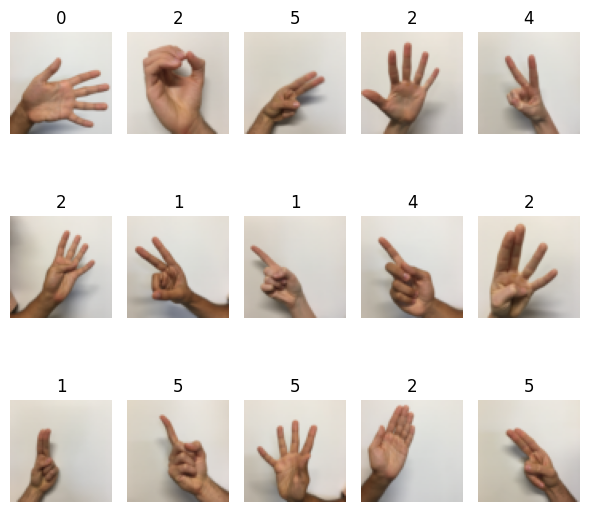

In [12]:
n_rows = 3
n_cols = 5

plt.figure(figsize=(6,6))
for i in range(n_rows * n_cols):
    axe = plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(next(img_iterator).numpy())
    plt.title(next(label_iterator).numpy())
    plt.axis('off')

plt.tight_layout()

# Data Preprocessing

### Normalizing Input

In [13]:
def normalize(img):
    img = tf.cast(img, tf.float32) / 255.0  # (64, 64, 3)
    img = tf.reshape(img, [-1, ])  # (64x64x3, )
    return img

There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the `map` method to apply the function passed as an argument to each of the elements.

In [14]:
x_train_mapDataset = x_train_Dataset.map(normalize)
x_test_mapDataset = x_test_Dataset.map(normalize)

x_train_mapDataset, x_test_mapDataset

(<_MapDataset element_spec=TensorSpec(shape=(12288,), dtype=tf.float32, name=None)>,
 <_MapDataset element_spec=TensorSpec(shape=(12288,), dtype=tf.float32, name=None)>)

### One Hot Encoding Output

In [15]:
def oneHotEncoding(y, n_classes=6):
    oneHot_matrix = tf.one_hot(indices=y, depth=n_classes)  # (n_samples, n_classes)
    oneHot_matrix = tf.reshape(oneHot_matrix, [n_classes, ])  # (n_classes, n_samples)
    return oneHot_matrix

In [16]:
tf.one_hot(indices=[0, 1, 2, 1], depth=3)

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [17]:
y_train_mapDataset = y_train_Dataset.map(lambda y: oneHotEncoding(y, n_classes=6))
y_test_mapDataset = y_test_Dataset.map(lambda y: oneHotEncoding(y, n_classes=6))

y_train_mapDataset, y_test_mapDataset

(<_MapDataset element_spec=TensorSpec(shape=(6,), dtype=tf.float32, name=None)>,
 <_MapDataset element_spec=TensorSpec(shape=(6,), dtype=tf.float32, name=None)>)

# Build a Model using Tensorflow

### Initialize Parameters

In [18]:
def init_params(layers: list[int], initializer='he', seed=None):
    L_including_inputLayer = len(layers)
    params = {}

    if initializer == 'xavier':
        init = tf.keras.initializers.GlorotNormal(seed=seed)
    elif initializer == 'he':
        init = tf.keras.initializers.HeNormal(seed=seed)
    elif initializer == 'lecun':
        init = tf.keras.initializers.LecunNormal(seed=seed)
    
    for i in range(1, L_including_inputLayer):
        params[f'W{i}'] = tf.Variable(init(shape=(layers[i], layers[i-1])))
        params[f'B{i}'] = tf.Variable(init(shape=(layers[i], 1)))

    return params

### Forward Pass

In [19]:
def forward(X, params):
    A = X
    L = len(params) // 2
    
    for i in range(1, L):
        A_prev = A
        Z = tf.add(tf.matmul(params[f'W{i}'], A_prev), params[f'B{i}'])
        Z = tf.cast(Z, tf.float32)
        A = tf.keras.activations.relu(Z)

    Z_output = tf.add(tf.matmul(params[f'W{L}'], A), params[f'B{L}'])
    Z_output = tf.cast(Z_output, tf.float32)

    return Z_output

### Total Loss each Mini Batch

In [20]:
def compute_totalLost_each_miniBatch(logits, labels):
    """
    Arguments:
    logits -- output of forward pass, (n_classes, n_samples)
    labels -- "true" labels vector, the same shape as Z3
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    logits = tf.transpose(logits)  # (n_samples, n_classes)
    labels = tf.transpose(labels)  # (n_samples, n_classes)
    
    loss_each_sample = tf.keras.losses.categorical_crossentropy(labels, logits, from_logits=True)
    '''
    from_logits = True tells TensorFlow that the logits need to be converted to probabilities (using softmax) 
    before computing the cross-entropy loss
    '''
    total_loss = tf.reduce_sum(loss_each_sample)
    return total_loss

In [21]:
logits = tf.constant([[2.0, 1.0, 0.1], 
                      [0.1, 1.2, 3.0]])  # Shape (n_classes, n_samples)
labels = tf.constant([[1, 0, 0], 
                      [0, 0, 1]])        # Shape (n_classes, n_samples)

compute_totalLost_each_miniBatch(logits, labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.19294944>

### Now, Build a Complete Model

In [22]:
def model(
    x_train_Dataset, y_train_Dataset, 
    x_test_Dataset, y_test_Dataset, 
    n_layers, 
    n_epochs, 
    batch_size=64, 
    learning_rate=0.001
):
    # List
    costs = []
    train_accuracies = []
    test_accuracies = []

    # Metrics
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Create tensorflow batches
    train_Dataset = tf.data.Dataset.zip((x_train_Dataset, y_train_Dataset))
    test_Dataset = tf.data.Dataset.zip((x_test_Dataset, y_test_Dataset))
    
    train_Batches = train_Dataset.batch(batch_size).prefetch(8)
    test_Batches = test_Dataset.batch(batch_size).prefetch(8)

    ### Init params
    params = init_params(n_layers, initializer='xavier', seed=1)
    ### Optimizer to update params
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    ### Training
    for epoch in range(1, n_epochs+1):
        
        total_loss_each_epoch = 0
        # We need to reset the object to start measuring from 0 the accuracy of each epoch
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        
        for (batch_x_Tensor, batch_y_Tensor) in train_Batches:
            
            # Forward pass and compute the cost of each batch
            with tf.GradientTape() as tape:
                Z_output = forward(tf.transpose(batch_x_Tensor), params)
                total_loss_each_batch = compute_totalLost_each_miniBatch(Z_output, tf.transpose(batch_y_Tensor))
            # Backward pass and compute gradients
            trainable_vars = [var for var in params.values()]
            grads = tape.gradient(total_loss_each_batch, trainable_vars)
            # Update parameters
            optimizer.apply_gradients(zip(grads, trainable_vars))

            # We accumulate the accuracy of all the batches in one epoch
            train_accuracy.update_state(batch_y_Tensor, tf.transpose(Z_output))

            # Compute the total loss of each epoch
            total_loss_each_epoch += total_loss_each_batch
        # Compute the average loss of each epoch    
        n_samples = train_Dataset.cardinality().numpy()
        avg_loss_each_epoch = total_loss_each_epoch / n_samples

        
        ### We evaluate the accuracy of the test set every epoch
        for (batch_x_Tensor, batch_y_Tensor) in test_Batches:
            Z_test_output = forward(tf.transpose(batch_x_Tensor), params)
            test_accuracy.update_state(batch_y_Tensor, tf.transpose(Z_test_output))
        
        ### Append to list
        costs.append(avg_loss_each_epoch)
        train_accuracies.append(train_accuracy.result())
        test_accuracies.append(test_accuracy.result())
        
        ### Print
        if epoch % 10 == 0 or epoch == 1:
            print('{:<15} after Epoch {:<4}: {:<25}'.format('Cost', epoch, avg_loss_each_epoch))
            print('{:<15} after Epoch {:<4}: {:<25}'.format('Train Accuracy', epoch, train_accuracy.result()))
            print('{:<15} after Epoch {:<4}: {:<25}'.format('Test Accuracy', epoch, test_accuracy.result()))
            print('-'*15)
            
    return params, costs, train_accuracies, test_accuracies

Notice the `tape.gradient` function: this allows you to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do.

Here you should take note of an important extra step that's been added to the batch training process: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [23]:
tf.data.Dataset.zip((x_train_mapDataset, y_train_mapDataset))

<_ZipDataset element_spec=(TensorSpec(shape=(12288,), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [24]:
tf.data.Dataset.zip((x_train_mapDataset, y_train_mapDataset)).cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1080>

In [25]:
batches = tf.data.Dataset.zip((x_train_mapDataset, y_train_mapDataset)).batch(8)
batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 12288), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [26]:
batches = tf.data.Dataset.zip((x_train_mapDataset, y_train_mapDataset)).batch(8).prefetch(8)
batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 12288), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [27]:
for batch_x, batch_y in batches.take(1):
    print(batch_x.shape)
    print('-')
    print(batch_y)  # type = tf.Tensor

(8, 12288)
-
tf.Tensor(
[[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]], shape=(8, 6), dtype=float32)


# Training

In [28]:
units_each_layer = [x_train_mapDataset.element_spec.shape[0], 25, 12, 6]

In [29]:
params, costs, train_accuracies, test_accuracies = model(x_train_mapDataset, y_train_mapDataset, 
                                                         x_test_mapDataset, y_test_mapDataset,
                                                         n_layers=units_each_layer,
                                                         n_epochs=120,
                                                         batch_size=32,
                                                         learning_rate=0.0001
                                                        )

Cost            after Epoch 1   : 1.8302439451217651       
Train Accuracy  after Epoch 1   : 0.17037037014961243      
Test Accuracy   after Epoch 1   : 0.20000000298023224      
---------------
Cost            after Epoch 10  : 1.577074408531189        
Train Accuracy  after Epoch 10  : 0.34259259700775146      
Test Accuracy   after Epoch 10  : 0.3083333373069763       
---------------
Cost            after Epoch 20  : 1.367186427116394        
Train Accuracy  after Epoch 20  : 0.4981481432914734       
Test Accuracy   after Epoch 20  : 0.4333333373069763       
---------------
Cost            after Epoch 30  : 1.1781784296035767       
Train Accuracy  after Epoch 30  : 0.6111111044883728       
Test Accuracy   after Epoch 30  : 0.5333333611488342       
---------------
Cost            after Epoch 40  : 1.0460909605026245       
Train Accuracy  after Epoch 40  : 0.6564815044403076       
Test Accuracy   after Epoch 40  : 0.5583333373069763       
---------------
Cost            afte

In [30]:
train_accuracies[:3]

[<tf.Tensor: shape=(), dtype=float32, numpy=0.17037037>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.19259259>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.22407408>]

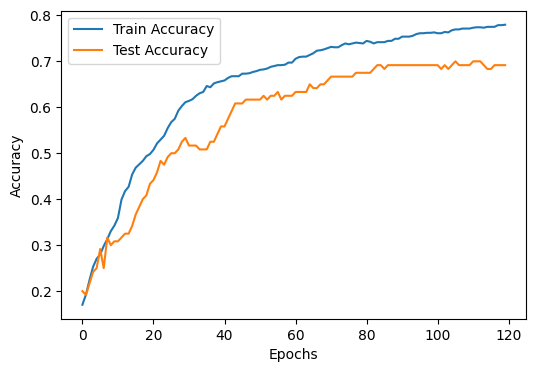

In [31]:
plt.figure(figsize=(6,4))
plt.plot(np.squeeze(train_accuracies), label='Train Accuracy')
plt.plot(np.squeeze(test_accuracies), label='Test Accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

# Predicting

In [32]:
list(y_test_Dataset)[:5]

[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>]

In [33]:
y_test_Array = np.squeeze(list(y_test_Dataset))
y_test_Array

array([0, 0, 0, 5, 1, 0, 3, 1, 5, 1, 5, 1, 3, 1, 1, 3, 5, 4, 0, 4, 5, 4,
       2, 5, 3, 5, 4, 2, 1, 2, 3, 1, 0, 3, 1, 1, 0, 4, 2, 3, 0, 3, 0, 2,
       3, 1, 2, 2, 0, 3, 4, 1, 2, 0, 4, 0, 4, 0, 4, 4, 5, 5, 2, 4, 4, 5,
       0, 1, 3, 5, 0, 4, 1, 2, 3, 4, 3, 5, 1, 5, 2, 0, 1, 4, 2, 4, 4, 1,
       4, 5, 5, 0, 0, 5, 5, 5, 3, 3, 5, 2, 2, 2, 0, 2, 5, 3, 0, 2, 3, 4,
       1, 3, 2, 4, 2, 2, 1, 3, 1, 3], dtype=int64)

In [34]:
x_test_Array = np.squeeze(list(x_test_Dataset))
x_test_Array.shape

(120, 64, 64, 3)

In [35]:
for x_test_Tensor in x_test_mapDataset.take(5):
    print(x_test_Tensor)

tf.Tensor([0.90588236 0.8784314  0.84705883 ... 0.8509804  0.8        0.75686276], shape=(12288,), dtype=float32)
tf.Tensor([0.90588236 0.8745098  0.84313726 ... 0.6901961  0.62352943 0.5647059 ], shape=(12288,), dtype=float32)
tf.Tensor([0.9019608  0.8784314  0.84705883 ... 0.81960785 0.7764706  0.73333335], shape=(12288,), dtype=float32)
tf.Tensor([0.9137255  0.8901961  0.85882354 ... 0.07843138 0.09019608 0.11372549], shape=(12288,), dtype=float32)
tf.Tensor([0.8862745  0.85490197 0.8235294  ... 0.7921569  0.7882353  0.78431374], shape=(12288,), dtype=float32)


In [36]:
def predict(x_Batches, params):
    predictions = []

    # Iterate over the dataset to extract the data
    for batch_x_Tensor in x_Batches:
        
        Z_pred = forward(tf.transpose(batch_x_Tensor), params)  # (n_classes, n_samples_each_batch)
        probabilities = tf.nn.softmax(Z_pred, axis=0)
        Y_pred = tf.argmax(probabilities, axis=0).numpy()  # (1, n_samples_each_batch)
        
        predictions.append(Y_pred)

    predictions = np.array(predictions)
    return predictions

In [37]:
x_Batches = x_test_mapDataset.batch(x_test_mapDataset.cardinality().numpy())
yPred_test_Array = predict(x_Batches, params)
yPred_test_Array

array([[5, 0, 0, 5, 1, 0, 3, 1, 4, 1, 5, 1, 5, 1, 4, 4, 5, 5, 0, 4, 5, 4,
        2, 5, 0, 5, 4, 4, 1, 5, 4, 1, 0, 4, 1, 1, 3, 4, 2, 3, 5, 3, 0, 2,
        3, 1, 1, 4, 2, 5, 4, 1, 2, 5, 4, 0, 4, 0, 4, 5, 5, 5, 2, 4, 3, 3,
        0, 1, 3, 5, 0, 5, 3, 1, 3, 4, 3, 5, 1, 5, 5, 0, 1, 3, 2, 4, 4, 4,
        4, 5, 4, 0, 0, 5, 5, 5, 3, 4, 5, 2, 2, 1, 0, 4, 5, 3, 0, 1, 3, 5,
        1, 4, 2, 3, 1, 1, 1, 3, 1, 3]], dtype=int64)

In [38]:
y_test_Array.shape, yPred_test_Array.shape

((120,), (1, 120))

In [39]:
diff = (y_test_Array != yPred_test_Array.reshape(-1, )).astype('int')
diff

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0])

In [40]:
mislabeled_indices = np.where(diff == 1)
mislabeled_indices

(array([  0,   8,  12,  14,  15,  17,  24,  27,  29,  30,  33,  36,  40,
         46,  47,  48,  49,  53,  59,  64,  65,  71,  72,  73,  80,  83,
         87,  90,  97, 101, 103, 107, 109, 111, 113, 114, 115], dtype=int64),)

In [41]:
n_misclasses = len(mislabeled_indices[0])
n_misclasses

37

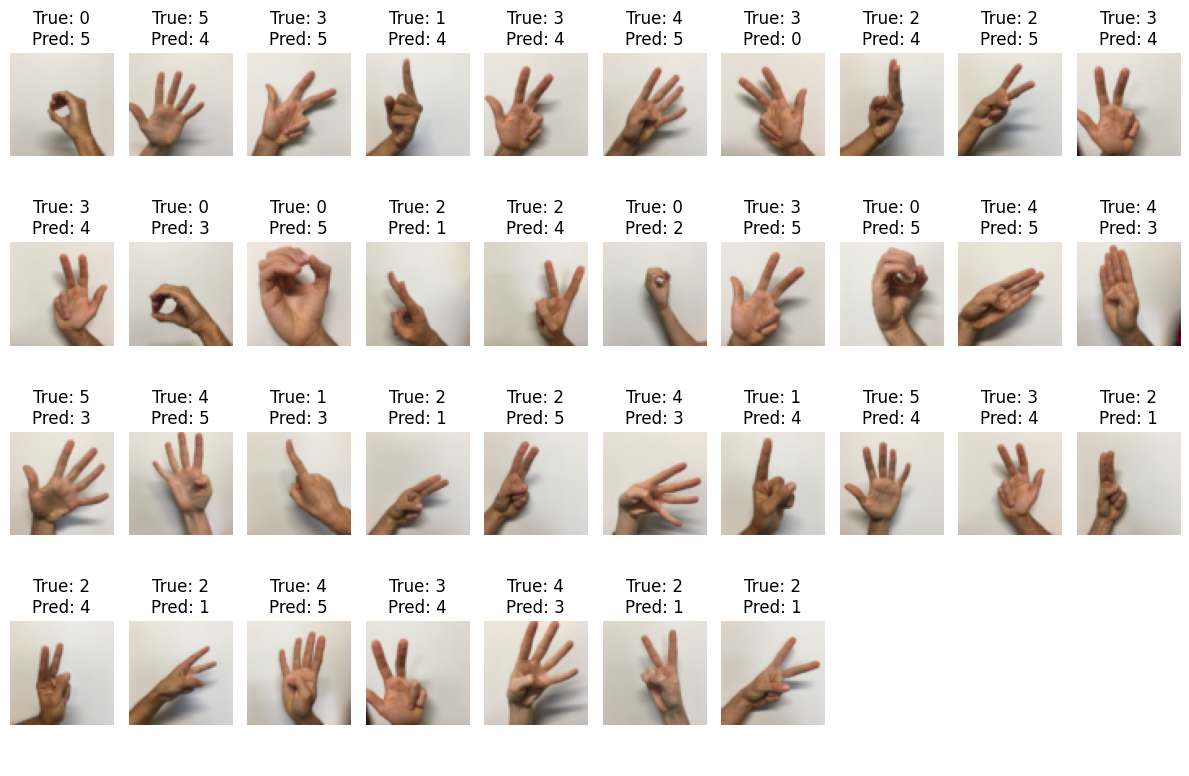

In [42]:
n_cols = 10
n_rows = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes = axes.flatten()
                   
for i, idx in enumerate(mislabeled_indices[0]):
    y_true = y_test_Array[idx]
    y_pred = yPred_test_Array[0][idx]
    
    axes[i].imshow(x_test_Array[idx])
    axes[i].set_title(f'True: {y_true}\nPred: {y_pred}')
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()